
1. Simulate some panel data. We’ll do some analysis similar to the Eclipse Bug Report paper, https://arxiv.org/pdf/1803.04129.pdf, but without the DID piece. Specifically,
  * Simulate N units over T discrete time steps.
  * Add confounding through a variable Z  between treated and untreated units which is constant over time. That is, $Z = Z_i$, and not $Z_{it}$ (where $i$ is an index that runs over units, and $t$ runs over time steps). In particular ...
  * Add a time-varying causal state where $D^*$ (as we defined it in class) is caused by $Z_i$. It should be a binary treatment which turns on and stays on for each test unit ($D^* = 1$) at a different time, but never turns on for control units ($D^* = 0$)
  * Compute counterfactuals $Y^0_{it}$ and $Y^1_{it}$ which are caused by $Z_i$.
2. Use your counterfactuals to estimate the time series causal effect. Plot it, and explain from the data generating process why it's correct.
3. Create a propensity score model for $D*$.
4. Match units to estimate the ATT.
5. Estimate the expected counterfactuals for the test group: $E[Y^1_t |D=1]$ and $E[Y^0_t |D=1]$. You’ll have to be careful: since all the units treatments don’t turn on at the same time, you’ll want to mask out the treatment units in the $D_{it}=0$ state when you’re taking your averages. Numpy’s masked array object can be useful here, numpy.ma.array
6. Use the time series you estimated in (4) to estimate the time-varying ATT.


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Question 1

In [58]:
units = 5000 #N
time_steps = 52 #T

p_z = .5
z = np.random.binomial(1, p_z, size=units) #Z

p_d = .25 + z / 2
d = np.random.binomial(1, p_d, size=units) #Causal state

start = np.random.randint(1, 52, size=units) #Start time for causal state
delta = 5 #Treatment effect

#N x T array of causal state over time D_it which stays on for treatment and never activates for control
d_it = np.array([[0] * (start[index]) + [delta] * (52 - start[index]) for index, treatment in enumerate(d)])

# taken from matrix_completion.ipynb
a_trend = np.arange(0, time_steps, 1)
individual_effects = np.random.normal(size=units)
A_trend = np.tile(a_trend, units).reshape(units, time_steps)
A_indiv = np.tile(individual_effects, time_steps).reshape(time_steps, units).T
Y_0 = A_trend + A_indiv #Y_0

Y_1 = A_trend + A_indiv + d_it #Y_1

Y = [Y_0[i] if d[i] == 0 else Y_1[i] for i in range(len(d))] #Y_0 if d == 0 ow Y_1

df = pd.DataFrame(Y)
df['d'] = d
df['Z'] = z
df['start'] = start

Question 2

How am I measuring the potential outcomes?  
Average y_it at each time step, I suppose  

In [59]:
df_y0 = pd.DataFrame(Y_0)
df_y1 = pd.DataFrame(Y_1)

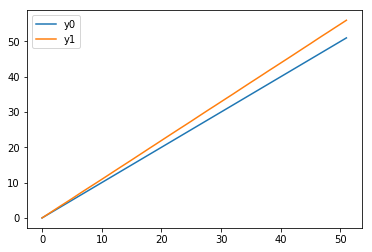

In [60]:
pd.DataFrame({'y0': df_y0.mean(), 'y1': df_y1.mean()}).plot()

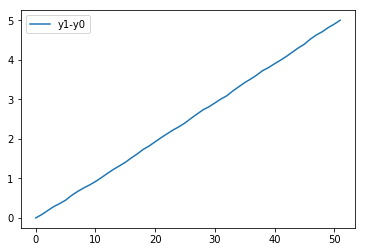

In [61]:
pd.DataFrame({'y1-y0': df_y1.mean() - df_y0.mean()}).plot()

At time T=52 the difference in $Y_1$ and $Y_0$ is given by:

In [62]:
df_y1.mean()[51] - df_y0.mean()[51]

5.0000000000000142

The data generating process adds a constant delta = 5 to the treatment group, beginning at a variable start time and continuing until T = 52. As expected the difference in the potential outcomes $Y_0, Y_1$ after T time steps is equal to that delta.

Question 3

In [72]:
from statsmodels.api import WLS, OLS
from sklearn.linear_model import LogisticRegression

In [73]:
var_list = [i for i in range(51)]

In [74]:
propensity_model = LogisticRegression(C=1e12)
propensity_model = propensity_model.fit(df[var_list], df['d'])
df['P_d1_t'] = propensity_model.predict_proba(df[var_list])[:, 1]

Question 4

$w_{i, ATT} = \frac{p_i}{1 - p_i}$ if $d_i = 0$, 1 if $d_i = 1$

In [78]:
df['wATT'] = (df['d'] == 1) * 1 + (df['d'] == 0) * df['P_d1_t'] / (1 - df['P_d1_t'])

coef_d = ATT = 4.74?

In [79]:
df['intercept'] = 1
model = WLS(df[51], df[['d', 'intercept']], weights=df['wATT'])
result = model.fit(cov_type='HC3')
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                     51   R-squared:                       0.304
Model:                            WLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                 2.019e+04
Date:                Wed, 05 Dec 2018   Prob (F-statistic):               0.00
Time:                        13:23:31   Log-Likelihood:                -13150.
No. Observations:                5000   AIC:                         2.630e+04
Df Residuals:                    4998   BIC:                         2.632e+04
Df Model:                           1                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
d              4.7418      0.033    142.088      0.000       4.676       4.807
intercept     51.2733      0.019   2754.136      0.000      51.237      51.310
==============================================================================
Omnibus:                      850.292   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16649.223
Skew:                           0.178   Prob(JB):                         0.00
Kurtosis:                      11.932   Cond. No.                         14.6
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

Question 5

Removed trend effects

In [53]:
units = 5000 #N
time_steps = 52 #T

p_z = .5
z = np.random.binomial(1, p_z, size=units) #Z

p_d = .25 + z / 2
d = np.random.binomial(1, p_d, size=units) #Causal state

start = np.random.randint(1, 52, size=units) #Start time for causal state
delta = 5 #Treatment effect

#N x T array of causal state over time D_it which stays on for treatment and never activates for control
d_it = np.array([[0] * (start[index]) + [delta] * (52 - start[index]) for index, treatment in enumerate(d)])

# taken from matrix_completion.ipynb
# but removed trend effects
a_trend = np.arange(0, time_steps, 1)
individual_effects = np.random.normal(size=units)
A_indiv = np.tile(individual_effects, time_steps).reshape(time_steps, units).T
Y_0 = A_indiv #Y_0

Y_1 = A_indiv + d_it #Y_1

Y = [Y_0[i] if d[i] == 0 else Y_1[i] for i in range(len(d))] #Y_0 if d == 0 ow Y_1

df = pd.DataFrame(Y)
df['d'] = d
df['Z'] = z
df['start'] = start